### 0. Import libraries and load data

In [8]:
import os
import sys
import json
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import tensorflow as tf
# import keras.utils as image
# from keras.models import Model
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# from keras.layers import Input, Conv2D, Conv2DTranspose

DATA_PATH = "../data/"
ENCODED_DATA_PATH = "../encoded_data/"
DATABASE_PATH = "database/database_lite.json"
QUERY_PATH = "query/query_lite.json"
SIMILARITY_FILE_NAME = "london_lite_gt.h5"


In [10]:
# load database data
with open(DATA_PATH + DATABASE_PATH, "r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])

# load query data
with open(DATA_PATH + QUERY_PATH, "r") as f:
    q_idx = json.load(f)
    q_imgs = np.array(q_idx["im_paths"])
    
# load relevance judgements
with h5py.File(DATA_PATH + SIMILARITY_FILE_NAME, "r") as f:
    sim = f["sim"][:].astype(np.uint8)


### 1. Pre-process images

In [47]:
def get_image_shapes(image_paths):
    """
    It returns the set of shapes of images loaded from the path given.
    """
    
    image_shapes = set()

    # create the set of image shapes
    for image_path in image_paths:
        img = plt.imread(os.path.join(DATA_PATH + image_path))
        image_shapes.add(img.shape)
        
    return image_shapes


In [48]:
def get_smallest_image_size(m_imgs_shapes, q_imgs_shapes):
    """
    This function finds the smallest image shape across the database and query images.
    Additionally, it adjusts the width and height so that they are divisible with 16.
    It represents a requirement for our architecture of the Convolutional Autoencoder.
    """

    smallest_shape = None
    smallest_size = sys.maxsize
    imgs_shapes = q_imgs_shapes.union(m_imgs_shapes)

    # find the smalles image shape
    for img_shape in imgs_shapes:
        image_size = img_shape[0] * img_shape[1] * img_shape[2]

        if image_size <= smallest_size:
            smallest_size = image_size
            smallest_shape = img_shape
            
    new_even_dims = []

    # adjust the found shape for the Convolutional Autoencoder
    for dim_index in range(len(smallest_shape) - 1):
        if smallest_shape[dim_index] % 8 == 1:
            new_even_dims.append(smallest_shape[dim_index] - smallest_shape[dim_index] % 8)
        else:
            new_even_dims.append(smallest_shape[dim_index])

    smallest_shape_even = (new_even_dims[0], new_even_dims[1], smallest_shape[2])
    print(f"\nSmallest image shape with even sizes is: {smallest_shape_even}")

    return smallest_shape_even


In [49]:
# get image shapes of database images
m_imgs_shapes = get_image_shapes(m_imgs)
print(f"Shapes of database images:\n{m_imgs_shapes}")

# get image shapes of query images
q_imgs_shapes = get_image_shapes(q_imgs)
print(f"\nShapes of query images:\n{q_imgs_shapes}")

# get the image shape that will be used throughout the project
smallest_image_shape = get_smallest_image_size(m_imgs_shapes, q_imgs_shapes)


Shapes of database images:
{(256, 455, 3), (256, 341, 3), (256, 367, 3)}

Shapes of query images:
{(256, 341, 3), (256, 455, 3)}

Smallest image shape with even sizes is: (256, 336, 3)


In [50]:
def load_images(image_paths, image_size):
    """
    It loads the images, downsample them and scale pixel values between 0 and 1.
    """

    # set a placeholder for images
    preprocessed_images = np.zeros(
        (len(image_paths), image_size[0], image_size[1], image_size[2])
    )

    for index, image_path in enumerate(image_paths):
        # preprocess each image
        raw_img = image.load_img(DATA_PATH + image_path)
        resized_img = tf.image.resize(raw_img, (image_size[0], image_size[1]))
        scaled_img = resized_img / 255
        array_img = image.img_to_array(scaled_img).astype("float32")
        preprocessed_images[index] = array_img
        
    return preprocessed_images


In [51]:
# load and preprocess database images
database_images = load_images(m_imgs, smallest_image_shape)
print(f"Shape of database dataset: {database_images.shape}")


# load and preprocess query images
query_images = load_images(q_imgs, smallest_image_shape)
print(f"Shape of query dataset: {query_images.shape}")


Shape of database dataset: (1000, 256, 336, 3)
Shape of query dataset: (500, 256, 336, 3)


In [52]:
def display_reshaped_image(database_images, m_imgs, image_index):
    """
    This function displays the original image with index image_index and its resized version.
    """

    fig, ax = plt.subplots(2, 1)
    fig.tight_layout()

    ax[0].imshow(plt.imread(os.path.join(DATA_PATH + m_imgs[image_index])))
    ax[0].set_title("Original image")

    ax[1].imshow(database_images[image_index])
    ax[1].set_title("Resized image")

    plt.show()


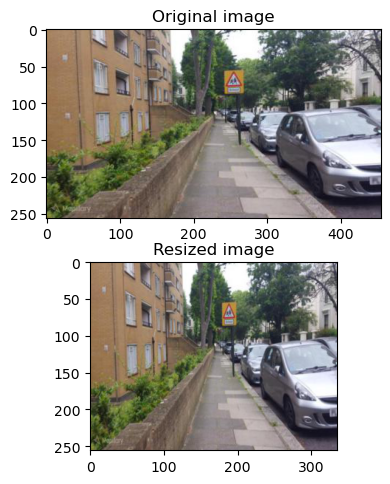

In [53]:
# display one original image and its resized version
display_reshaped_image(database_images, m_imgs, image_index=6)


### 2. Optimize the autoencoder

In [54]:
def build_model(image_shape, learning_rate=0.001, display_architecture=False):
    """
    This function defines the architecture of the Convolutional Autoencoder, compiles the model and
    displays the architecture if requested.    
    """

    # define the layers of the encoder
    input_layer = Input(shape=image_shape)   
    conv_1 = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
    conv_2 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(conv_1)
    conv_3 = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(conv_2)
    bootleneck = Conv2D(38, (3, 3), activation='relu', padding='same', strides=2)(conv_3)

    # define the layers of the dencoder
    conv_t_1 = Conv2DTranspose(38, kernel_size=3, strides=2, activation='relu', padding='same')(bootleneck)
    conv_t_2 = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_1)
    conv_t_3 = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_2)
    conv_t_4 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_3)
    output_layer = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv_t_4)

    # define autoencoder and encoder objects
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=bootleneck)   

    # compile the model
    autoencoder.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))

    # display the layers if display_architecture is True
    if display_architecture:
        print(autoencoder.summary())

    return autoencoder, encoder

In [55]:
def plot_loss_evolution(history, batch_size, learning_rate, show_image=True, save_image=False):
    """
    It displays the training and validation loss. It can also store the plot in the results directory.
    """

    fig, _ = plt.subplots(1, 1)

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])

    plt.title(f"Loss evolution - batch size {batch_size} | learning rate {learning_rate}")
    plt.legend(["Training", "Validation"])

    if show_image:
        plt.show()

    if save_image:
        fig.savefig(f'../results/batch_size_{batch_size}_learning_rate_{learning_rate}.png', dpi=300)

    if not show_image:
        plt.close()

In [56]:
def optimize_model():
    """
    This represents the main optimization function that trains the model with various configurations of hyperparameters.
    In addition, it stores the details of each experiment in a CSV file and the plots of train and validation losses. This 
    is done so that after the optimization, the results can be compared and the best model can be re-trained on the entire 
    dataset of database images.
    """

    results = {"epochs": [], "batch size": [], "learning rate": [], "train loss": [], "val loss": []}

    # define hyperparameters
    batch_sizes = [1, 16, 32, 64, 128]
    learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

    # define the early stopping that monitors the validation loss
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # iterate over hyperparameters
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            # build and compile the model
            autoencoder, _ = build_model(smallest_image_shape, learning_rate)

            # train the model, using 10% as validation data
            history = autoencoder.fit(
                database_images,
                database_images,
                epochs=100,
                batch_size=batch_size,
                validation_split=0.1,
                shuffle=True,
                callbacks=[callback],
                verbose=2,
            )

            # generate plot and store it
            plot_loss_evolution(history, batch_size, learning_rate, show_image=False, save_image=True)

            # crate a Pandas DataFrame with various details and store it as a CSV file
            results["epochs"].append(len(history.history["loss"]))
            results["batch size"].append(batch_size)
            results["learning rate"].append(learning_rate)
            results["train loss"].append(history.history["loss"][-1])
            results["val loss"].append(history.history["val_loss"][-1])

            pd.DataFrame(results).to_csv("./results/optimization_results.csv", index=None)

In [57]:
# This function was executed once and the results are evaluated in the cells below.
# optimize_model()

### 3. Re-train the best autoencoder on all database images

In [58]:
# laod the CSV file that contains the optimization results
optimization_results = pd.read_csv("../results/optimization_results.csv").sort_values("val loss")
optimization_results

epochs  batch size  learning rate  train loss  val loss
1       50           1         0.0005    0.001568  0.001794
2       25           1         0.0010    0.001916  0.002271
8       40          16         0.0050    0.002688  0.002875
0       38           1         0.0001    0.002781  0.003443
6       57          16         0.0005    0.003353  0.003956
12      41          32         0.0010    0.003499  0.004058
3       13           1         0.0050    0.004036  0.004352
11      58          32         0.0005    0.004053  0.005277
7       19          16         0.0010    0.005207  0.006104
14      22          32         0.0100    0.005521  0.006164
18      28          64         0.0050    0.005722  0.006413
5       61          16         0.0001    0.005741  0.006806
4       17           1         0.0100    0.006059  0.006839
24      30         128         0.0100    0.006446  0.007443
9       16          16         0.0100    0.004756  0.007556
23      27         128         0.0050    0.006480  0.007820
16      39          64         0.0005    0.006316  0.007878
17      51          64         0.0010    0.006939  0.007940
13      18          32         0.0050    0.006505  0.008328
10      91          32         0.0001    0.006992  0.008427
22      42         128         0.0010    0.007357  0.008620
15      82          64         0.0001    0.007377  0.008823
19      18          64         0.0100    0.008615  0.009619
21      38         128         0.0005    0.007962  0.009658
20      97         128         0.0001    0.008778  0.010544

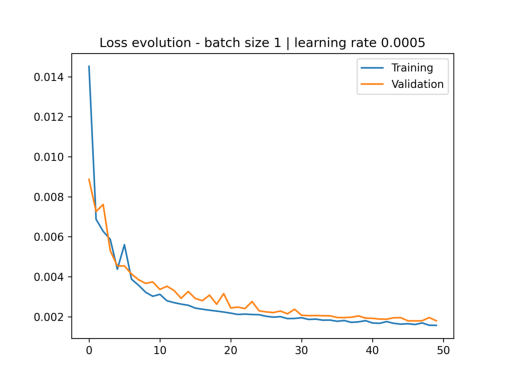

In [59]:
# get the hyperparameters of the model with the lowest validation loss
epochs_number = int(optimization_results.iloc[0, 0])
optimum_batch_size = int(optimization_results.iloc[0, 1])
optimum_learning_rate = optimization_results.iloc[0, 2]

# load and display the loss evolution of this model
loss_evolution = plt.imread(f"../results/batch_size_{optimum_batch_size}_learning_rate_{optimum_learning_rate}.png")

fig = plt.imshow(loss_evolution)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [60]:
# build the model that uses the optimal found learning rate 
autoencoder, encoder = build_model(smallest_image_shape, learning_rate=optimum_learning_rate, display_architecture=True)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 336, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 168, 8)       224       
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 84, 16)        1168      
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 42, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 21, 38)        10982     
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 32, 42, 38)        13034     
 Transpose)                                                      
                                                           

In [61]:
# re-train model on the entire train set using the best hyperparameters
history = autoencoder.fit(database_images, database_images, epochs=epochs_number, batch_size=optimum_batch_size)

Epoch 1/50
1000/1000 [==============================] - 77s 74ms/step - loss: 0.0145
Epoch 2/50
1000/1000 [==============================] - 61s 61ms/step - loss: 0.0067
Epoch 3/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0057
Epoch 4/50
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0046
Epoch 5/50
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0038
Epoch 6/50
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0036
Epoch 7/50
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0033
Epoch 8/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0032
Epoch 9/50
1000/1000 [==============================] - 60s 60ms/step - loss: 0.0030
Epoch 10/50
1000/1000 [==============================] - 62s 62ms/step - loss: 0.0029
Epoch 11/50
1000/1000 [==============================] - 61s 61ms/step - loss: 0.0028
Epoch 12/50
1000/1000 [==============================] - 62s 62

### 4. Visualize reconstructed images

In [62]:
def display_reconstructed_images(autoencoder, database_images, query_images):
    """
    This function displays for train and validation sets three random pairs of original and reconstructed images. 
    """

    fig, ax = plt.subplots(3, 4)
    fig.set_size_inches(18, 9)

    for i in range(3):
        database_image_index = random.randint(0, len(database_images) - 1)
        original_databse_image = database_images[database_image_index]
        reconstructed_database_image = autoencoder.predict(np.array([original_databse_image]), verbose=0)[0]

        ax[i][0].imshow(original_databse_image)
        ax[i][1].imshow(reconstructed_database_image)

        if i == 0:
            ax[i][0].set_title("Original\ndatabase")
            ax[i][1].set_title("Reconstructed\ndatabase")

        query_image_index = random.randint(0, len(query_images) - 1)
        original_query_image = query_images[query_image_index]
        reconstructed_query_image = autoencoder.predict(np.array([original_query_image]), verbose=0)[0]

        ax[i][2].imshow(original_query_image)
        ax[i][3].imshow(reconstructed_query_image)

        if i == 0:
            ax[i][2].set_title("Original\nquery")
            ax[i][3].set_title("Reconstructed\nquery")

    plt.show()

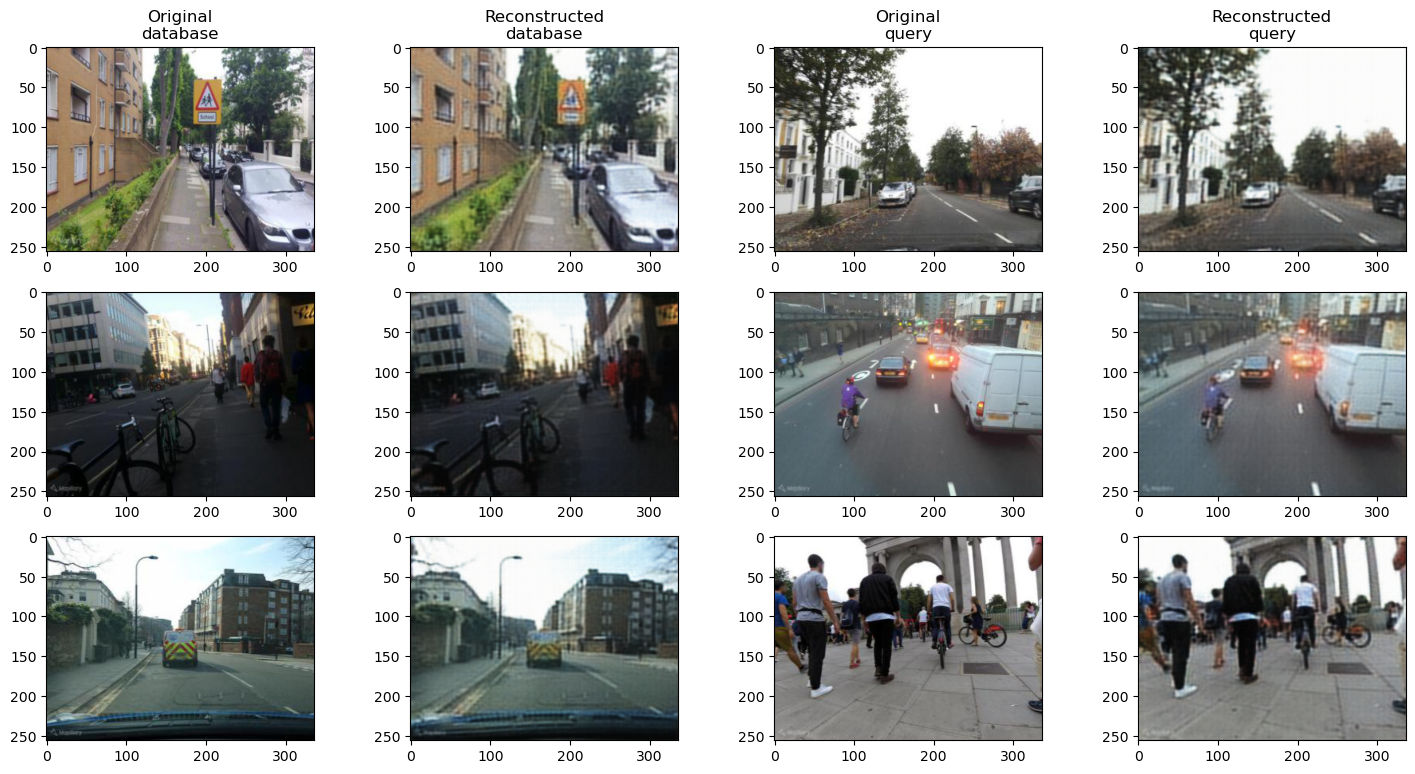

In [63]:
display_reconstructed_images(autoencoder, database_images, query_images)

### 5. Encode images and store encodings

In [64]:
def store_encoded_images(encoder, images, dataset_name):
    """
    It encodes the given set of images and stores their encodings.
    """

    images_no = images.shape[0]
    encoded_images = encoder.predict(images).reshape(images_no, -1)

    print(f"Storing encoded {dataset_name} images. Dataset size: {encoded_images.shape}\n")

    with open(ENCODED_DATA_PATH + dataset_name + "_encoded.npy", "wb") as f:
        np.save(f, encoded_images)

In [65]:
# encode and store database and query images
store_encoded_images(encoder, database_images, "database_lite")
store_encoded_images(encoder, query_images, "query_lite")

32/32 [==============================] - 1s 41ms/step
Storing encoded database_lite images. Dataset size: (1000, 12768)

16/16 [==============================] - 1s 43ms/step
Storing encoded query_lite images. Dataset size: (500, 12768)



### 6. Load encoded images

In [33]:
def load_encoded_images(dataset_name):
    """
    This function loads the encoded images of the specified data set.
    """

    print(f"Loading encoded {dataset_name} images")

    with open(ENCODED_DATA_PATH + dataset_name + "_encoded.npy", "rb") as f:
        encoded_images = np.load(f)  

    return encoded_images

In [34]:
# load encoded database and query images
encoded_database_images = load_encoded_images("database_lite")
encoded_query_images = load_encoded_images("query_lite")

Loading encoded database_lite images
Loading encoded query_lite images


# Evaluation

In [35]:
def euclidean_distance(a: np.ndarray, b: np.ndarray):
  return np.linalg.norm(a - b)

In [36]:
def get_ranking(query: np.ndarray, database: np.ndarray) -> tuple[np.ndarray, list]:
  distances = [euclidean_distance(query, row) for row in database]
  return np.argsort(distances), distances

In [37]:
def retrieve_similar_images_q(query: np.ndarray, n: int = 10) -> list[tuple]:
  ranking, distances = get_ranking(query, database=encoded_database_images)
  result = []

  limit = n if n > 0 else len(ranking) - 1

  for order in range(limit):
    index = ranking[order]
    result.append({"rank": order, "distance": distances[index], "index": index})

  return result


def retrieve_similar_images(query: int, n: int = 10) -> list[tuple]:
  return retrieve_similar_images_q(encoded_query_images[query], n)

In [38]:
def plot_similar_images(query_index: int, retrieved: list) -> None:
  num_similar = len(retrieved)
  fig, axs = plt.subplots(1, num_similar + 1, figsize=(20, 10))

  # Plot the query image
  axs[0].imshow(plt.imread(os.path.join(DATA_PATH, q_imgs[query_index])))
  axs[0].set_title("Query Image")

  # Plot the most similar images
  for i in range(num_similar):
      similar_image_path = os.path.join(DATA_PATH, m_imgs[retrieved[i]["index"]])
      axs[i + 1].imshow(plt.imread(similar_image_path))
      axs[i + 1].set_title(f"Similar Image {i + 1}\nEuclidean Distance:\n{retrieved[i]['distance']:.2f}")
  plt.tight_layout()
  plt.show()

In [39]:
def retreive(query: int):
  similar_images = retrieve_similar_images(query, 10)
  plot_similar_images(query, similar_images)

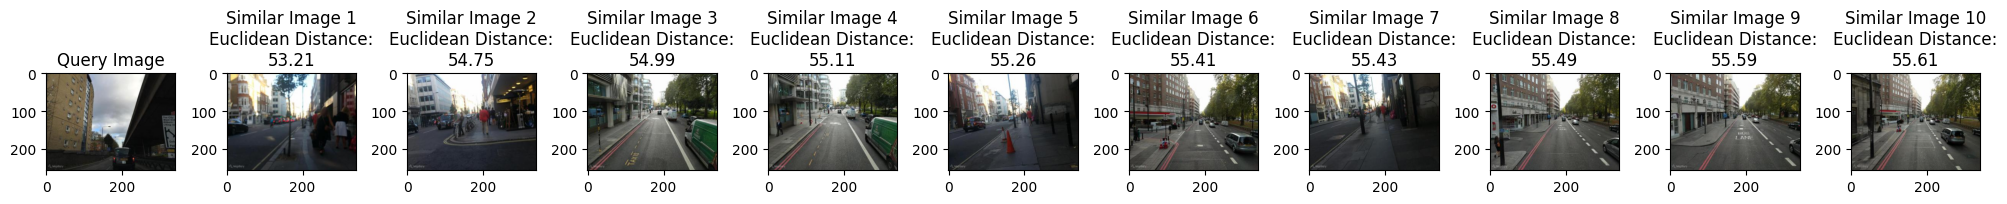

In [40]:
retreive(0)

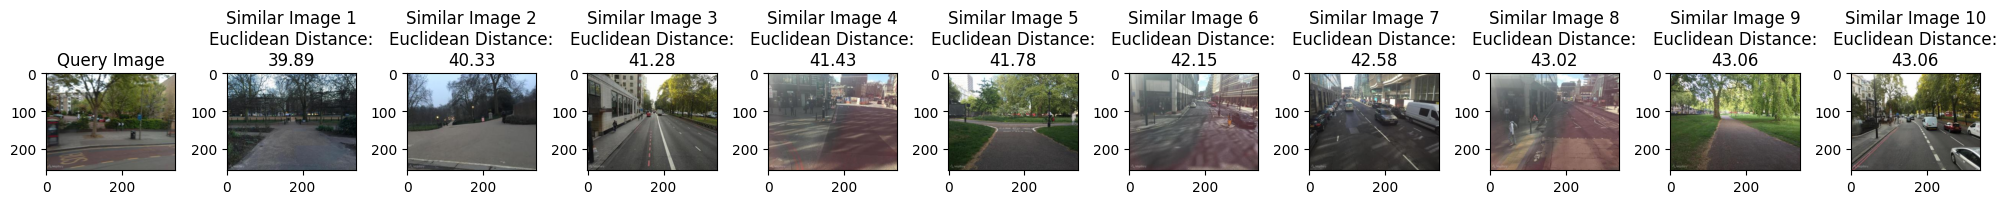

In [41]:
retreive(100)

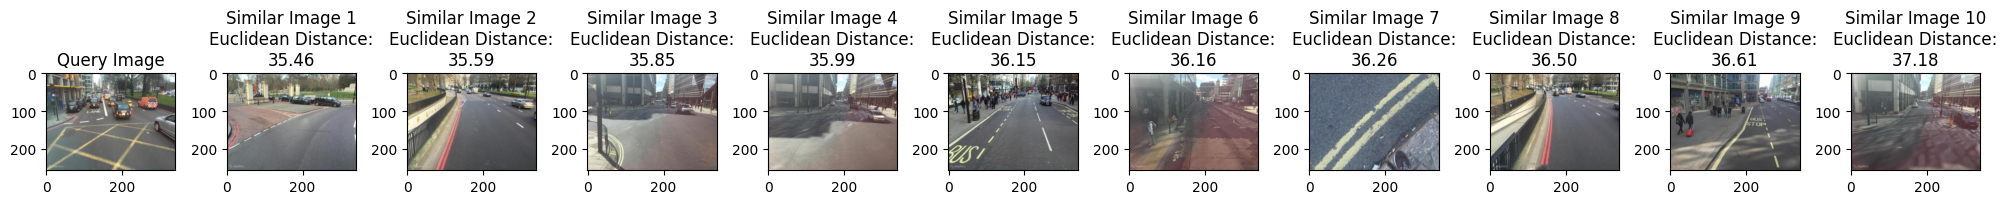

In [89]:
retreive(200)

In [43]:
def precision_at_k(relevant: list, retreived: list, k: int = 5):
  rel = 0
  if len(retreived) >= k:
    for r in retreived[:k]:
      if r in relevant:
        rel+=1
  return rel / k

def average_precision(relevant: list, retrieved: list) -> float:
  '''Returns the average precision for a relevant and retrieved list'''
  average_precision = 0
  # iterate through the list of retrieved documents to find a relevant entry
  for i in range(1, len(retrieved)):
    if retrieved[i] in relevant:
      # calculate average precision at r
      average_precision += precision_at_k(relevant, retrieved, i)

  return average_precision / len(relevant)

def r_precision(relevant: list, retrieved: list) -> float:
  r = len(relevant)
  true_positive = 0
  
  for i in range(0, r):
    if retrieved[i] in relevant:
      true_positive += 1

  return true_positive / r

metrics = [average_precision, r_precision]

In [44]:
sim.shape

(500, 1000)

In [45]:
def calculate_metrics(query: int):
  similar = retrieve_similar_images(query, -1)
  expected = sim[query]

  similar = [r["index"] for r in similar]
  expected = np.where(expected == 1)[0]

  return [metric(expected, similar) for metric in metrics]

In [46]:
calculate_metrics(12)

[0.012142842614480703, 0.0]

## Calculate Metrics For All Queries

In [47]:
metrics_for_queries = np.array([calculate_metrics(i) for i in range(len(q_imgs))])

In [48]:
mean_avg_precision = np.sum(metrics_for_queries[:, 0]) / len(metrics_for_queries)
print(mean_avg_precision)

0.028772047009679877


In [49]:
mean_r_precision = np.sum(metrics_for_queries[:, 1]) / len(metrics_for_queries)
print(mean_r_precision)

0.04580358824182353


# Statistical Tests

## Method From Assignment 2

In [1]:
# Method B from assignment
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray
import pickle
import sklearn
from sklearn.cluster import KMeans

# load pre-computed descriptors
f = open('../data/ORB-descriptors-map.bin', 'rb')
descriptors = pickle.load(f)
f.close()
print(descriptors.shape)

# k-means
K = 35  # number of clusters (equivalent to the number of words) we want to estimate
num_initialization = 5 # Number of time the k-means algorithm will be run with different centroid seeds.
# Run the k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=1)
clusters = kmeans.fit(descriptors)  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_
print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")

(50000, 256)
Initialization complete
Iteration 0, inertia 4625969.0.
Iteration 1, inertia 2751398.2184384027.
Iteration 2, inertia 2726061.5869525387.
Iteration 3, inertia 2717226.9755191817.
Iteration 4, inertia 2712647.710437417.
Iteration 5, inertia 2709787.3960534288.
Iteration 6, inertia 2707925.9303213703.
Iteration 7, inertia 2706591.9708545962.
Iteration 8, inertia 2705566.112708699.
Iteration 9, inertia 2704748.4099732386.
Iteration 10, inertia 2704065.9965074747.
Iteration 11, inertia 2703509.7248694794.
Iteration 12, inertia 2703014.5563191.
Iteration 13, inertia 2702582.1638336354.
Iteration 14, inertia 2702203.3391404813.
Iteration 15, inertia 2701871.394244086.
Iteration 16, inertia 2701590.971756759.
Iteration 17, inertia 2701328.0965930126.
Iteration 18, inertia 2701087.5086372914.
Iteration 19, inertia 2700883.880400121.
Iteration 20, inertia 2700693.460738581.
Iteration 21, inertia 2700527.6734440206.
Iteration 22, inertia 2700389.4939442305.
Iteration 23, inertia 270

In [14]:
from tqdm import tqdm
import os
import skimage
from scipy.spatial import distance as ssp
from skimage.feature import ORB
from skimage.color import rgb2gray
descriptor_extractor = ORB(n_keypoints=50)

def vector_distance(v1: list, v2: np.ndarray, method: str) -> float | None:
    """Computes vector distance with different methods"""
    if method == "euclidean":
        return ssp.euclidean(v1, v2)
    elif method == "manhattan":
        return ssp.cityblock(v1, v2)
    elif method == "minkowski":
        return ssp.minkowski(v1, v2)
    elif method == "chebychev":
        return ssp.chebyshev(v1, v2)
    elif method == "cosine":
        return ssp.cosine(v1, v2)
    else:
        return None


# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image

    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    
    for i in range(n_descriptors):
        ## BEGIN ANSWER
        # extract descriptors for current keypoint and convert to int
        f_vector = [int(j == True) for j in img_descriptors[i]]
        #for each descriptor add +1 to bow_vector[j], where j is the closest centroid
        
        sim_centroids = []
        for c in range(n_centroids):
            #compute using different similarities and check later with the MAP which is better        
            sim_centroids.append(vector_distance(f_vector, centroids[c], "cosine"))
        
        cl = min(sim_centroids)
        bow_vector[np.where(sim_centroids == cl)[0][0]] += 1
                
        ## END ANSWER
    return bow_vector

# Test the implementation of the BoW vector computation
img = plt.imread(os.path.join(DATA_PATH, q_imgs[0]))
img = rgb2gray(img)

descriptor_extractor.detect_and_extract(img)  
# keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
query_img_descriptors = descriptor_extractor.descriptors 

bow = bag_of_words(centroids, query_img_descriptors)
print("Size of the bow vector: ", bow.shape)
print("Bow vector: ", bow)


Size of the bow vector:  (35,)
Bow vector:  [0. 3. 2. 0. 4. 0. 0. 2. 0. 4. 2. 4. 4. 2. 2. 0. 1. 4. 0. 0. 5. 2. 1. 2.
 0. 0. 1. 0. 0. 3. 0. 1. 1. 0. 0.]


In [15]:
bow_map_images = None
# loop over the images in the map set
for img_name in tqdm(m_imgs):
    # load image
    img = plt.imread(os.path.join(DATA_PATH, img_name))
    img = rgb2gray(img)
    
    # extract the keypoints and corresponding descriptors (50 ORB descriptors)
    descriptor_extractor.detect_and_extract(img)
    img_descriptors = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

100%|██████████| 1000/1000 [02:29<00:00,  6.69it/s]


In [16]:
from sklearn import preprocessing
orig_bow_map_images = bow_map_images

# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)

In [17]:
# receives as input the:
#   - bag of words vectors of the map images
#   - the bag of work vector of the query image
def retrieve_images(map_bow_vectors, query_bow):
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None  # use this to return most similar
    
    ## BEGIN ANSWER
    sim_scores = {'euclidean':[], 'manhattan':[], 'minkowski':[], 'chebychev':[], 'cosine':[]}
    # use the previously defined function to compute vector distance and store them in sim_scores
    for m in sim_scores.keys():
        for v in range(n_map_bow_vectors):
            s = vector_distance( map_bow_vectors[v], query_bow, m)
            sim_scores[m].append(s)

    # sort each vector inside new dict
    sort_indices = {'euclidean':[], 'manhattan':[], 'minkowski':[], 'chebychev':[], 'cosine':[]}
    for m in sim_scores.keys():
        sort_indices[m] = np.argsort(sim_scores[m])
        
    most_similar = sort_indices['euclidean']
    
    ## END ANSWER
    
    return most_similar

In [23]:
n_img = len(q_imgs)

method_b_metrics = []

all_relevant_img: list[list[float]] = []
all_retrieved_img: list[list[float]] = []

for q in range(n_img):
  img = plt.imread(DATA_PATH + q_imgs[q])
  img = rgb2gray(img)
  # compute bag of words
  descriptor_extractor.detect_and_extract(img)  
  query_img_descriptors = descriptor_extractor.descriptors 
  bow = bag_of_words(centroids, query_img_descriptors)

  # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
  bow = scaler.transform(bow.reshape(-1, 1).transpose())
  bow = bow.transpose().reshape(-1)

  # Retrieve the indices of the top-10 similar images from the map
  all_retrieved_img.append(retrieve_images(bow_map_images, bow))
  # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
  all_relevant_img.append(np.where(sim[q, :] == 1)[0])

for i in range(n_img):
  method_b_metrics.append([metric(all_relevant_img[i], all_retrieved_img[i]) for metric in metrics])

In [90]:
all_relevant_img[122]

array([128, 129, 130, 131, 132, 133, 134, 135])

In [25]:
method_b_metrics = np.array(method_b_metrics)

In [86]:
mean_avg_precision_method_b = np.sum(method_b_metrics[:, 0]) / len(method_b_metrics)
print(mean_avg_precision_method_b)

0.007271065672709469


## Distribution of Precision Differences

$P - X$

In [55]:
diff = metrics_for_queries[:, 0] - method_b_metrics[:, 0]

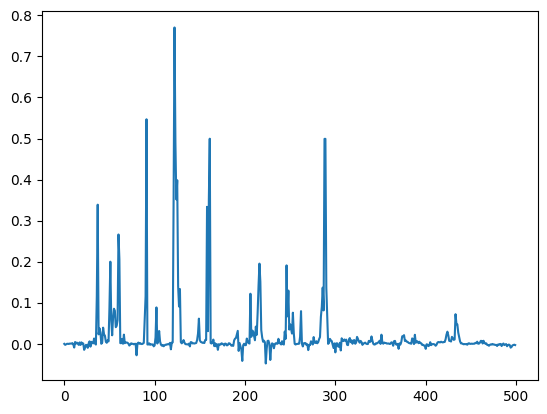

In [56]:
plt.plot(diff)

In [78]:
median_value = np.median(diff)

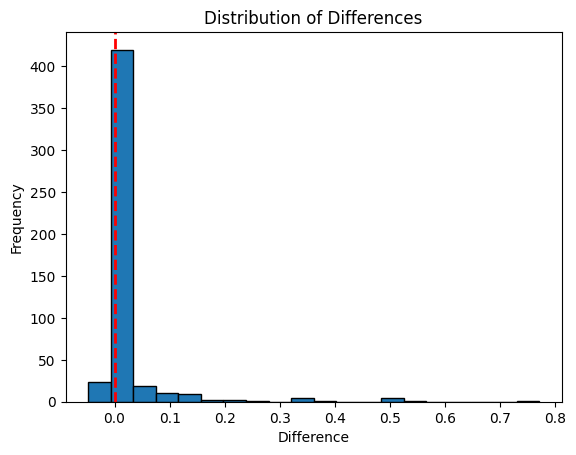

In [79]:
plt.hist(diff, bins=20, edgecolor='black')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label='Median')
plt.title('Distribution of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()


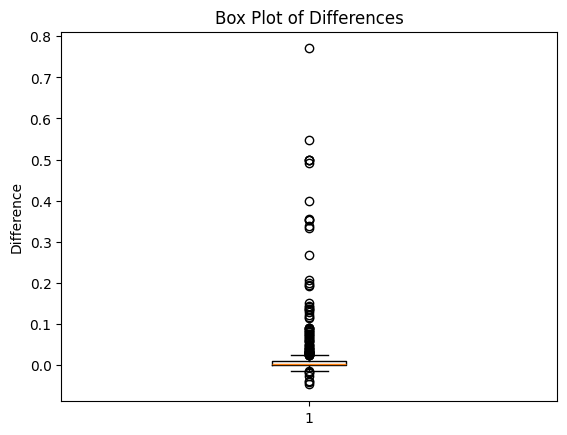

In [69]:
plt.boxplot(diff)
plt.title('Box Plot of Differences')
plt.ylabel('Difference')
plt.show()

In [66]:
# alpha = 0.05
from scipy.stats import shapiro
stat, p_value = shapiro(diff)
print(f'Statistic: {stat}, p-value: {p_value}')

# Check the p-value to determine symmetry
if p_value > 0.05:
    print('The data appears to be normally distributed.')
else:
    print('The data does not appear to be normally distributed.')

Statistic: 0.3517099618911743, p-value: 1.2643906234513574e-38
The data does not appear to be normally distributed.


In this test the null hypothesis is that the two systems come from the binomial distribution.
rejecting the null hypothesis means that system A is better than system B.

In [85]:
from scipy.stats import binomtest

# Assuming 'differences' is the array of differences between paired observations
num_positive_signs = sum(d > 0 for d in diff)
num_negative_signs = sum(d < 0 for d in diff)

# Perform the Sign test using a binomial test
result = binomtest(min(num_positive_signs, num_negative_signs), n=num_positive_signs + num_negative_signs)

print(f'Number of positive signs: {num_positive_signs}')
print(f'Number of negative signs: {num_negative_signs}')
print(f'p-value: {result.pvalue}')
print(f'statistic: The estimate of the proportion of successes. {result.statistic}')

# Check the p-value to determine significance
if result.pvalue > 0.05:
    print('There is no significant difference between paired observations.')
else:
    print('There is a significant difference between paired observations.')

Number of positive signs: 329
Number of negative signs: 163
p-value: 5.904606468962701e-14
statistic: The estimate of the proportion of successes. 0.3313008130081301
There is a significant difference between paired observations.


# Visualization

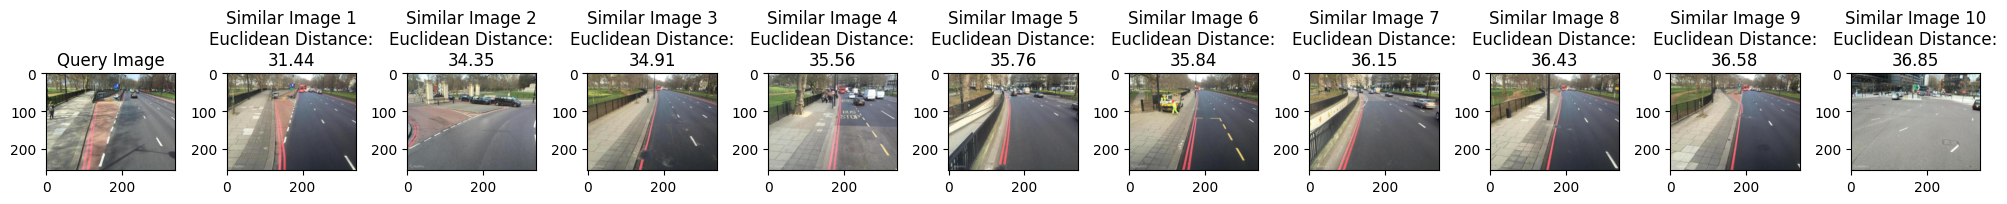

In [405]:
retreive(291)

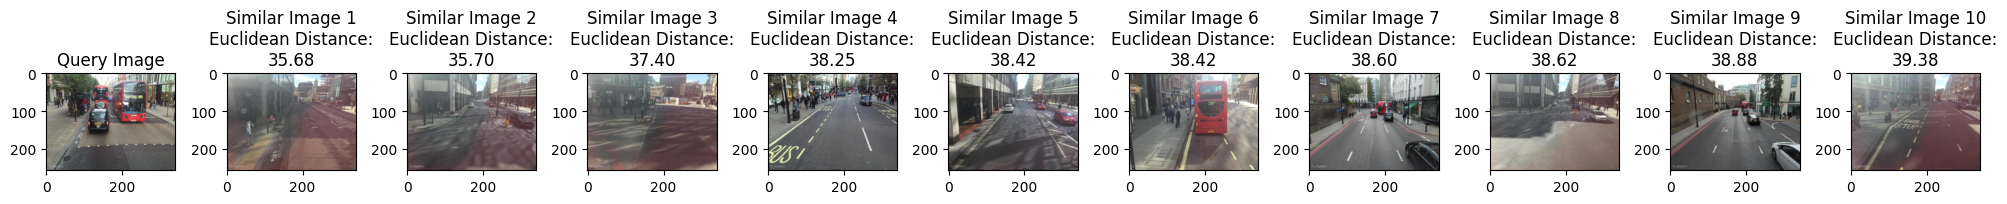

In [106]:
retreive(300)

In [114]:
def orb_retrieve(query: int):
  orb_based = [m_imgs[x] for x in all_retrieved_img[query]]

  fig, axs = plt.subplots(1, 10, figsize=(20, 10))

  axs[0].imshow(plt.imread(os.path.join(DATA_PATH, q_imgs[query])))

  for i in range(1, len(orb_based[:10])):
    axs[i].imshow(plt.imread(os.path.join(DATA_PATH, orb_based[i])))

  plt.tight_layout()

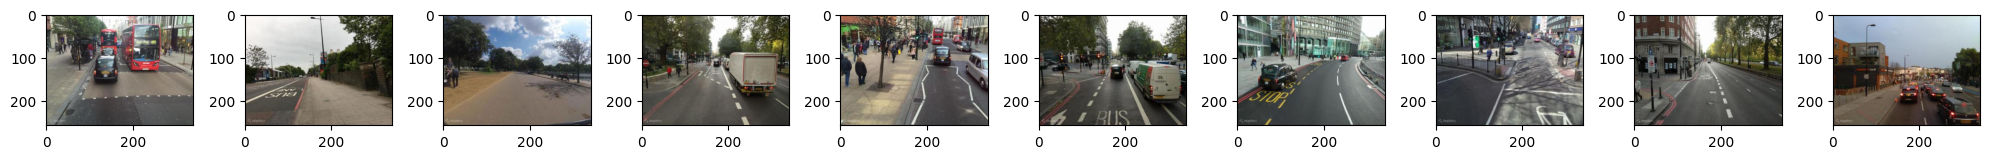

In [115]:
orb_retrieve(300)

In [363]:
sim[36]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [364]:
q_idx['loc'][36]

[695724.3302246662, 5711852.516931932, 222.63]

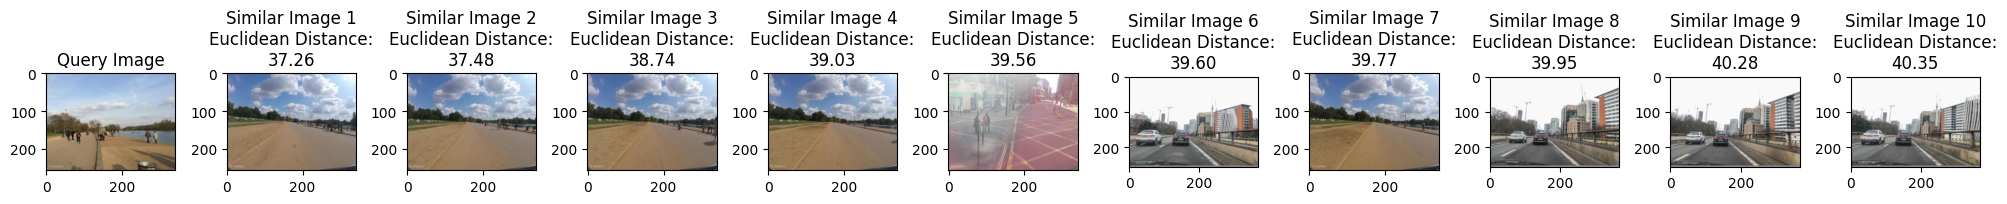

In [366]:
retreive(121)

In [367]:
np.where(sim[121] == 1)

(array([123, 124, 125, 126, 127, 128, 129, 130, 131]),)

In [266]:
retrieve_similar_images(121)

[{'rank': 0, 'distance': 37.25527, 'index': 128},
 {'rank': 1, 'distance': 37.47796, 'index': 129},
 {'rank': 2, 'distance': 38.74186, 'index': 130},
 {'rank': 3, 'distance': 39.03285, 'index': 131},
 {'rank': 4, 'distance': 39.555984, 'index': 838},
 {'rank': 5, 'distance': 39.60447, 'index': 0},
 {'rank': 6, 'distance': 39.770008, 'index': 132},
 {'rank': 7, 'distance': 39.949932, 'index': 4},
 {'rank': 8, 'distance': 40.28456, 'index': 3},
 {'rank': 9, 'distance': 40.35134, 'index': 1}]

In [323]:
index = 121
# test_map = np.array([m_loc[x] for x in np.where(sim[index] == 1)[0]])
test_map = np.array([m_idx["loc"][r["index"]] for r in retrieve_similar_images(121)])
print(test_map)
query_test = np.array(q_loc[index])

[[6.96468076e+05 5.70989508e+06 9.68500000e+01]
 [6.96473569e+05 5.70989463e+06 9.41100000e+01]
 [6.96479622e+05 5.70989443e+06 8.88400000e+01]
 [6.96485688e+05 5.70989479e+06 8.88400000e+01]
 [6.98944292e+05 5.70909543e+06 2.20554400e+02]
 [6.95725083e+05 5.71143726e+06 8.81663513e+01]
 [6.96491465e+05 5.70989510e+06 8.91100000e+01]
 [6.95792278e+05 5.71144066e+06 8.60141907e+01]
 [6.95777260e+05 5.71143904e+06 9.35202332e+01]
 [6.95741709e+05 5.71143881e+06 8.68587036e+01]]


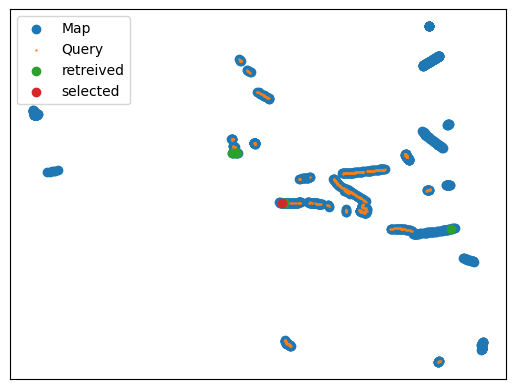

In [327]:
plt.scatter(m_loc[:,0],m_loc[:,1], label="Map")
plt.scatter(q_loc[:,0],q_loc[:,1], label="Query", s=0.5)
# plt.annotate("map", [test_map[: 0], test_map[: 1]])
plt.scatter(test_map[:, 0], test_map[:, 1], label="retreived")
plt.scatter(query_test[0], query_test[1], label="selected")
#plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()